In [1]:
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.transforms import v2

# Library imports
import math
import random
import pandas as pd
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

from PIL import Image
import torchvision.transforms as T
from subprocess import Popen, PIPE
import re

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
labels_map_inverted = {v: k for k, v in labels_map.items()}

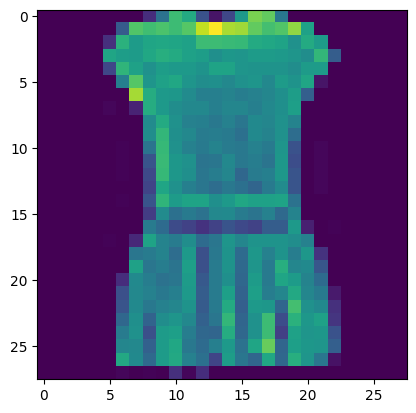

In [3]:
img,label=training_data[3]
lol=img.numpy()
plt.imshow(lol.squeeze());

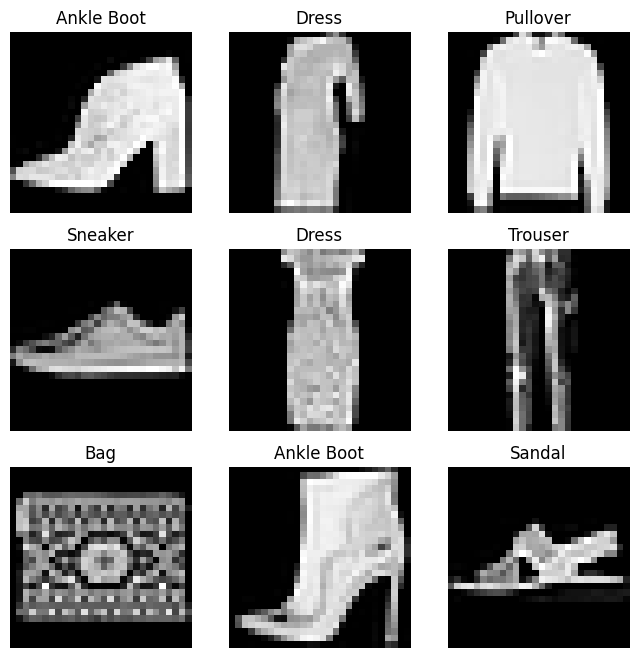

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# GAN Pennylane


In [5]:
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Primero se verifica con los datos de digitos que se obtenga el mismo resultado que en el tutorial

In [6]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

Se define ahora una clase para los datos de Mnist Fashion

In [7]:
class ClothesDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, train_frame, label='T-Shirt', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_frame = train_frame
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = [train for train in training_data if train[-1]==labels_map_inverted[label]]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image,label=self.df[idx]

        if self.transform:
            image = self.transform(image)
        
        # Return image and label
        return image, label

Se transforman los datos con resize para pasarlos de 28x28 a 24x24

In [8]:
image_size = 28  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = ClothesDataset(train_frame=training_data,label='Ankle Boot',transform=v2.Resize(size=(28,28)))
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
# dataset = ClothesDataset(train_frame=training_data,label='Trouser',transform=None)
# dataloader = torch.utils.data.DataLoad2er(
#     dataset, batch_size=batch_size, shuffle=True, drop_last=True
# )

c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


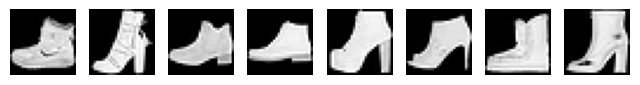

In [9]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [10]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size,image_size * image_size),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(image_size * image_size, 16),
            nn.ReLU(),
            # nn.Linear(64, 16),
            # nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 49  # Number of subgenerators for the patch method / N_G

image_size = 28  # Height / width of the square images
batch_size = 1

In [12]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [14]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [15]:
lrG = 0.1  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 600  # Number of training iterations


In [16]:

discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)
# checkpoint_gen = torch.load('./data/Experimento 2/Ankle Boot/model/generator/gen_latest.pth')
# generator.load_state_dict(checkpoint_gen)
# checkpoint_dis = torch.load('./data/Experimento 2/Ankle Boot/model/discriminator/dis_latest.pth')
# discriminator.load_state_dict(checkpoint_dis)

# Binary cross entropy
criterion = nn.BCELoss()


# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise_b = torch.rand(200, n_qubits, device=device) * math.pi / 2
fixed_noise_s = torch.rand(8, n_qubits, device=device) * math.pi / 2


# Iteration counter
counter =0

# Collect images for plotting later
results = []
loss_gen = []
loss_dis = []
loss_dis_real = []
loss_dis_fake = []

fid_list = []


In [17]:
while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1
        loss_gen.append(errG)
        loss_dis.append(errD)

        # Show loss valuesx
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            torch.save(discriminator.state_dict(), './model/discriminator/dis_latest.pth')
            torch.save(generator.state_dict(), './model/generator/gen_latest.pth')

            # Save images every 50 iterations
            if counter % 50 == 0:
                test_images_bunch = generator(fixed_noise_b).view(200,1,image_size,image_size).cpu().detach()
                smaller_bunch = generator(fixed_noise_s).view(8,1,image_size,image_size).cpu().detach()
                results.append(smaller_bunch)
                for j, im in enumerate(test_images_bunch):
                    np_arr = im.numpy()
                    transform=T.ToPILImage()
                    imt=transform(im)
                    imt.save(f"./generated_fid/{j}.png")
                    
                stdout = Popen('python -m pytorch_fid ./data/generated_fid ./data/original_data/Ankle_Boot-28', shell=True, stdout=PIPE).stdout
                output = stdout.read()
                fid =float(re.findall('[0-9]+\.[0-9]+',str(output))[0])
                fid_list.append(fid)


        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.311, Generator Loss: 0.671
Iteration: 20, Discriminator Loss: 1.236, Generator Loss: 0.700
Iteration: 30, Discriminator Loss: 1.067, Generator Loss: 0.702
Iteration: 40, Discriminator Loss: 0.895, Generator Loss: 0.760
Iteration: 50, Discriminator Loss: 0.730, Generator Loss: 0.824
Iteration: 60, Discriminator Loss: 0.602, Generator Loss: 0.935
Iteration: 70, Discriminator Loss: 0.496, Generator Loss: 1.108
Iteration: 80, Discriminator Loss: 0.449, Generator Loss: 1.198
Iteration: 90, Discriminator Loss: 0.411, Generator Loss: 1.445
Iteration: 100, Discriminator Loss: 0.246, Generator Loss: 1.844
Iteration: 110, Discriminator Loss: 0.219, Generator Loss: 1.834
Iteration: 120, Discriminator Loss: 0.112, Generator Loss: 2.360
Iteration: 130, Discriminator Loss: 0.124, Generator Loss: 2.465
Iteration: 140, Discriminator Loss: 0.088, Generator Loss: 2.892
Iteration: 150, Discriminator Loss: 0.081, Generator Loss: 3.077
Iteration: 160, Discriminator Loss

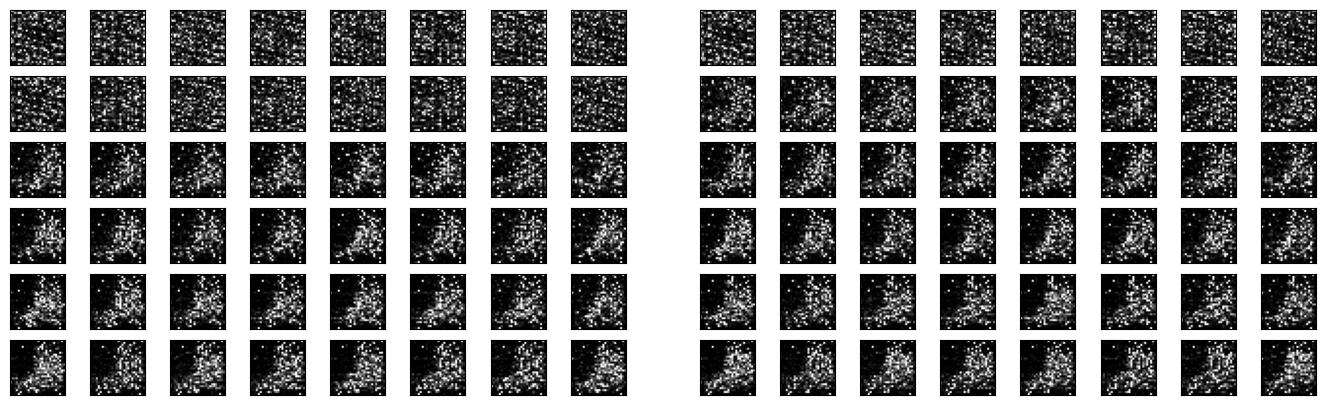

In [ ]:
fig = plt.figure(figsize=(17, 5))
outer = gridspec.GridSpec(6, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        # if j==0:
        #     ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

In [ ]:
from PIL import Image
import torchvision.transforms as T
for i, images in enumerate(results):
    images = torch.squeeze(images, dim=1)    
    for j, im in enumerate(images):
        np_arr = im.numpy()
        transform=T.ToPILImage()
        imt=transform(im)
        imt.save(f"./generated/{j}-{(i+1)*50}.png")
        # imt.show()

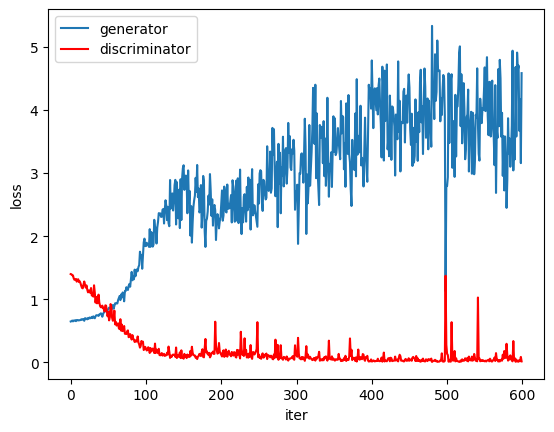

In [ ]:
list_loss_gen = [loss_gen[i].detach().numpy().tolist() for i in range(len(loss_gen))]
list_loss_dis = [loss_dis[i].detach().numpy().tolist() for i in range(len(loss_dis))]

plt.plot(list_loss_gen,label='generator')
plt.plot(list_loss_dis,color='red',label='discriminator')
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend()

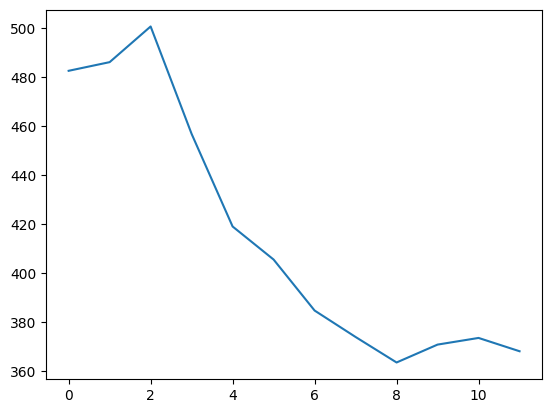

In [ ]:
plt.plot(fid_list,label='fid')

In [ ]:
with open(r'./fid.txt', 'w') as fp:
    for item in fid_list:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [ ]:
with open(r'./generator.txt', 'w') as fp:
    for item in loss_gen:
        # write each item on a new line
        fp.write("%s\n" % item.item())
    print('Done')

Done


In [ ]:
with open(r'./discriminator.txt', 'w') as fp:
    for item in loss_dis:
        # write each item on a new line
        fp.write("%s\n" % item.item())
    print('Done')

Done


In [ ]:
with open(r'./discriminator_real.txt', 'w') as fp:
    for item in loss_dis_real:
        # write each item on a new line
        fp.write("%s\n" % item.item())
    print('Done')
with open(r'./discriminator_fake.txt', 'w') as fp:
    for item in loss_dis_fake:
        # write each item on a new line
        fp.write("%s\n" % item.item())
    print('Done')